In [ ]:
'''
    state_dicts = [
        'state_dicts/long/state_dict_gru_1.pth',
        'state_dicts/long/state_dict_gru_2.pth',
        'state_dicts/long/state_dict_gru_3.pth'
    ]
    '''
    '''
    state_dicts = [
        'state_dicts/long/state_dict_bigru_1.pth',
        'state_dicts/long/state_dict_bigru_2.pth',
        'state_dicts/long/state_dict_bigru_3.pth'
    ]
    ''' 
    '''
    state_dicts = [
        'state_dicts/long/state_dict_lstm_1.pth',
        'state_dicts/long/state_dict_lstm_4.pth', 
        'state_dicts/long/state_dict_lstm_5.pth',
        'state_dicts/long/state_dict_lstm_3.pth',
        'state_dicts/long/state_dict_lstm_2.pth'
    ]
    '''
    '''
    
    state_dicts = [
        'state_dicts/long/state_dict_bilstm_1.pth',
        'state_dicts/long/state_dict_bilstm_4.pth',
        'state_dicts/long/state_dict_bilstm_2.pth',
        'state_dicts/long/state_dict_bilstm_3.pth'
    ]
    '''
    '''
    state_dicts = [
        'state_dicts/long/state_dict_gru_1.pth',
        'state_dicts/long/state_dict_gru_2.pth',
        'state_dicts/long/state_dict_gru_3.pth'
    ]
    '''
    '''
    state_dicts = [
        'state_dicts/long/state_dict_bigru_1.pth',
        'state_dicts/long/state_dict_bigru_2.pth',
        'state_dicts/long/state_dict_bigru_3.pth'
    ]
'''

In [2]:
import pickle
import torch
import torch.nn as nn
import random
import numpy as np
from model import Model


def create_dict():
    p_dict = {}
    for a in range(20):
        p_dict[a] = list()
    return p_dict

def load_dataset(path):
    d = pickle.load( open( path, "rb" ) )
    return d['x_test'], d['vocab']

def batches(data, batch_size):
    """ Yields batches of sentences from 'data', ordered on length. """
    random.shuffle(data)
    for i in range(0, len(data), batch_size):
        sentences = data[i:i + batch_size]
        sentences.sort(key=lambda l: len(l), reverse=True)
        yield [torch.LongTensor(s) for s in sentences]

def step(model, sents, device):
    """ Performs a model inference for the given model and sentence batch.
    Returns the model otput, total loss and target outputs. """
    x = nn.utils.rnn.pack_sequence([s[:-1] for s in sents])
    y = nn.utils.rnn.pack_sequence([s[1:] for s in sents])
    
    if device.type == 'cuda':
        x, y = x.cuda(), y.cuda()
    out = model(x)
    return out, y
    
def topk_accuracy(prob, target, k,p_dicts, p_dict_idx):
    _, pred = torch.topk(input=prob, k=k, dim=1)
    pred = pred.t()
    correct = pred.eq(target.data.expand_as(pred))
    single_correct_tensor = sum([c for c in correct])
    for i,size in enumerate(target.batch_sizes):
        if i < 20:
            start = sum(target.batch_sizes[0:i])
            p_i = single_correct_tensor[start:start + size]
            p_dicts[p_dict_idx][i].extend(p_i.tolist())

def test_accuracy(state_dict,data):
    device = torch.device("cpu" if not torch.cuda.is_available() else "cuda")
    x_test, vocab = load_dataset(data)
    model = Model(vocab_size=214, embedding_dim=20, hidden_dim=100, gru_layers=1, dropout=0.0)
    batch_size = 20
    model.load_state_dict(torch.load(state_dict),strict=False)
    model.eval()
    model.to(device)
    
    dicts = [create_dict(), create_dict(), create_dict()]
    with torch.no_grad():
        for sents in batches(x_test, batch_size):
            out, y = step(model, sents, device)
            #calc_accuracy(out,y,0)
            topk_accuracy(prob=out,target=y,k=1,p_dicts=dicts,p_dict_idx=0)
            topk_accuracy(prob=out,target=y,k=2,p_dicts=dicts,p_dict_idx=1)
            topk_accuracy(prob=out,target=y,k=3,p_dicts=dicts,p_dict_idx=2)
    
    return dicts

def roundoff(num):
    return "{:.5f}".format(num)

def test_run():
    '''
    state_dicts = [
        'state_dicts/total/state_dict_total_gru_1.pth',
        'state_dicts/total/state_dict_total_gru_2.pth',
        'state_dicts/total/state_dict_total_gru_3.pth'
    ]
    '''
    '''
    state_dicts = [
        'state_dicts/total/state_dict_total_bigru_1.pth',
        'state_dicts/total/state_dict_total_bigru_2.pth',
        'state_dicts/total/state_dict_total_bigru_3.pth'
    ]
    '''
    '''
    state_dicts = [
        'state_dicts/total/state_dict_total_lstm_1.pth',
        'state_dicts/total/state_dict_total_lstm_2.pth',
        'state_dicts/total/state_dict_total_lstm_3.pth'
    ]
    '''
    
    state_dicts = [
        'state_dicts/total/state_dict_total_bilstm_1.pth',
        'state_dicts/total/state_dict_total_bilstm_2.pth',
        'state_dicts/total/state_dict_total_bilstm_3.pth'
    ]
    
    
    
    data = './data/prepared_dataset.p'
    #data = './data/long.p'
        
    d1 = test_accuracy(state_dicts[0],data)
    d2 = test_accuracy(state_dicts[1],data)
    d3 = test_accuracy(state_dicts[2],data)
    
    print_lists = [[], [], []]
    u = 0
    
    print('precision@K','standard deviation')
    accuracy_scores = []
    for a, b, c in zip(d1,d2,d3):
        for j in a:
            p_scores = [np.mean(a[j]),np.mean(b[j]),np.mean(c[j])]
            avg = roundoff(np.mean(p_scores))
            stdd = roundoff(np.std(p_scores))
            latex_string = avg +' $\pm$ ' + stdd
            print_lists[u].append(latex_string)
            if u == 0:
                accuracy_scores.append(np.mean(p_scores))
        u += 1
    t = 1
    for s1,s2,s3 in zip(print_lists[0],print_lists[1],print_lists[2]):
        print(t,'&',s1,'&',s2,'&',s3,'\\\\')
        t += 1
    
    pickle.dump( accuracy_scores, open( "first_n_accuracy/total/first_n_acc_bilstm.p", "wb" ) )

In [3]:

test_run()

Model(
  (embedding): Embedding(214, 20)
  (recurrent_layer): LSTM(20, 100, bidirectional=True)
  (fully_connected): Linear(in_features=200, out_features=214, bias=True)
)
Model(
  (embedding): Embedding(214, 20)
  (recurrent_layer): LSTM(20, 100, bidirectional=True)
  (fully_connected): Linear(in_features=200, out_features=214, bias=True)
)
Model(
  (embedding): Embedding(214, 20)
  (recurrent_layer): LSTM(20, 100, bidirectional=True)
  (fully_connected): Linear(in_features=200, out_features=214, bias=True)
)
precision@K standard deviation
precision@K standard deviation
precision@K standard deviation
1 & 0.93648 $\pm$ 0.00451 & 0.94380 $\pm$ 0.00593 & 0.95093 $\pm$ 0.00566 \\
2 & 0.93316 $\pm$ 0.00115 & 0.95018 $\pm$ 0.00077 & 0.96025 $\pm$ 0.00026 \\
3 & 0.93179 $\pm$ 0.00023 & 0.94718 $\pm$ 0.00049 & 0.95633 $\pm$ 0.00009 \\
4 & 0.93136 $\pm$ 0.00006 & 0.94550 $\pm$ 0.00023 & 0.95458 $\pm$ 0.00020 \\
5 & 0.93384 $\pm$ 0.00050 & 0.94888 $\pm$ 0.00062 & 0.95770 $\pm$ 0.00056 \\
6 & 0.

In [4]:
first_n_acc_gru = pickle.load( open( "first_n_accuracy/total/first_n_acc_gru.p", "rb" ) )
first_n_acc_bigru = pickle.load( open( "first_n_accuracy/total/first_n_acc_bigru.p", "rb" ) )
first_n_acc_lstm = pickle.load( open( "first_n_accuracy/total/first_n_acc_lstm.p", "rb" ) )
first_n_acc_bilstm = pickle.load( open( "first_n_accuracy/total/first_n_acc_bilstm.p", "rb" ) )

In [10]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
sns.set_style('white')

# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

def plot_graph(list1,list2,label1,label2,path):
    plt.figure()
    ax = plt.figure().gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    ax.yaxis.grid()
    plt.yticks(np.arange(0, 1.1, step=0.1))

    xr = range(1,21)
    plt.xticks(xr)

    plt.plot(xr,list1,'go-')
    plt.plot(xr,list2,'ro-')

    plt.xlabel('n')
    plt.ylabel('precission@1')
    plt.legend([label1,label2])
    plt.savefig(path)
    plt.show()


<Figure size 432x288 with 0 Axes>

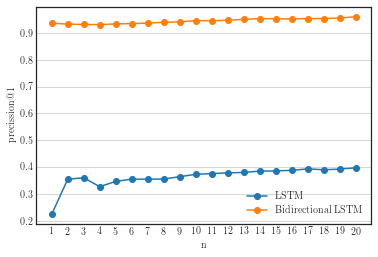

In [6]:
plot_graph(first_n_acc_lstm,first_n_acc_bilstm,'LSTM','Bidirectional LSTM','img/first_n_acc_lstm.pdf')

<Figure size 432x288 with 0 Axes>

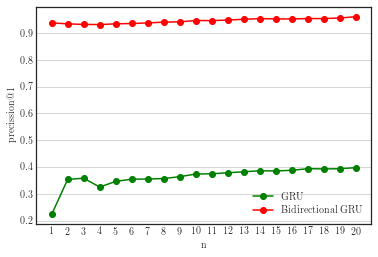

In [11]:
plot_graph(first_n_acc_gru,first_n_acc_bigru,'GRU','Bidirectional GRU','img/first_n_acc_gru.pdf')